In [20]:
import sys
sys.path.append('..')
from cmost_exposure import Exposure
#from cmost_source import ...
from astropy.convolution import convolve_fft, Gaussian2DKernel

import numpy as np
import scipy.optimize
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
from fit_2dgauss import Fit2DGauss

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

fit = Fit2DGauss()

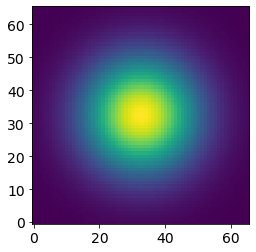

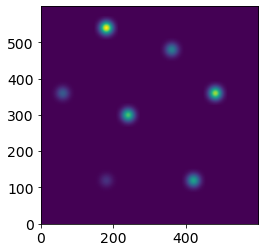

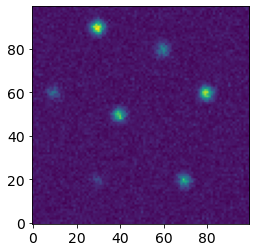

In [23]:
# Pixel size is 1 arcsec, PSF FWHM = 2 pixels = 2 arcsec
pixel_size = 1 * u.arcsec
psf_fwhm = 2 * u.arcsec
src_frame_size = 11 # In pixels
im_frame_size = 100 # In pixels
sky_rate = 0.015 * u.ph / u.s
exposure = 300. * u.s

oversample = 6
pixel_size_init = pixel_size / oversample
src_frame_size_init = src_frame_size * oversample
im_frame_size_init = im_frame_size * oversample

# Create empty oversampled image
im_array = np.zeros([im_frame_size_init,im_frame_size_init]) * u.ph / u.s

# Create PSF kernel
psf_kernel = Gaussian2DKernel(psf_fwhm / pixel_size_init, x_size=src_frame_size_init, y_size=src_frame_size_init)
psf_array = psf_kernel.array

plt.figure()
plt.imshow(psf_array, origin='lower')
plt.show()

# Create image with sources as delta functions
src_cr = np.array([1,2,3,4,5,6,7]) * u.ph / u.s
src_pos = np.array([[0.3,0.1,0.6,0.7,0.4,0.8,0.3],[0.2,0.6,0.8,0.2,0.5,0.6,0.9]]) # Xs and Ys, fractional positions cos that's what we did last time

source_inv = np.array([src_pos[1],src_pos[0]]) # Create array of all ys and all xs
source_pix = (source_inv.transpose() * np.array(im_array.shape)).transpose().astype(int)
im_array[tuple(source_pix)] += src_cr

# Now convolve with the PSF
im_psf = convolve_fft(im_array.value, psf_kernel) * im_array.unit

plt.figure()
plt.imshow(im_psf.value, origin='lower')
plt.show()

# Bin up the image by oversample parameter to the correct pixel size
shape = (im_frame_size, oversample, im_frame_size, oversample)
im_binned = im_psf.reshape(shape).sum(-1).sum(1)
im_binned[im_binned < 0] = 0

# Convert to observed source counts
im_counts = im_binned * exposure
im_sky = np.ones(im_counts.shape) * sky_rate * exposure

# Observe! Includes sky rate
im_poisson = (np.random.poisson(im_counts.value) + np.random.poisson(im_sky.value)) * im_array.unit

plt.figure()
plt.imshow(im_poisson.value, origin='lower')
plt.show()
